# **Section C (Algorithm implementation using packages)**

In [ ]:
!pip install tabulate
!pip install imbalanced-learn

In [ ]:
import os
import cv2
import random
import pickle
import tabulate
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.feature import hog, local_binary_pattern
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
drive.mount('/content/drive')
images_path ='/content/drive/MyDrive/ML/Assignment_2/Part_C/data/'
labels_path ='/content/drive/MyDrive/ML/Assignment_2/Part_C/label.csv'
best_model_path =   '/content/drive/MyDrive/ML/Assignment_2/Part_C/Models/best_model.pkl'
features_save_path = '/content/drive/MyDrive/ML/Assignment_2/Part_C/Models/extracted_features.pkl'
best_model_testing_set_path  = '/content/drive/MyDrive/ML/Assignment_2/Part_C/Models/best_model_testing_set.pkl'
best_model_training_set_path = '/content/drive/MyDrive/ML/Assignment_2/Part_C/Models/best_model_training_set.pkl'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labels_df = pd.read_csv(labels_path)

In [ ]:
def load_image(img_name, true_label):

    try:
        with Image.open(os.path.join(images_path, img_name)) as img:
            return img_name, {'image': img.copy(), 'label': true_label, 'size': img.size}

    except Exception as e:
        print(f"Error loading image {img_name}: {e}")
        return img_name, None

### Loading Images

In [ ]:
def load_images():

    images = {}
    image_names = labels_df['filename']

    with ThreadPoolExecutor(max_workers=128) as executor:
        results = list(tqdm(executor.map(load_image, image_names, labels_df['label']), total=len(image_names), colour='green'))

        images = {img_name: data for img_name, data in results if data is not None}

        executor.shutdown(wait=True)

    return images

In [ ]:
images = load_images()
print(f"\n\nLoaded \033[92m{len(images)}\033[0m Images into Memory.\n")

100%|██████████| 12600/12600 [00:17<00:00, 707.75it/s]



Loaded 12600 Images into Memory.



# **Part A: EDA**

In [ ]:
class_distribution = labels_df['label'].value_counts()
class_distribution

label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64

### **a) Distribution of Image Sizes**

In [ ]:
pd.DataFrame([img['size'] for img in images.values()], columns=['width', 'height']).describe()

width        height
count  12600.000000  12600.000000
mean     260.381032    196.573571
std       39.919281     35.281402
min       84.000000     84.000000
25%      254.000000    181.000000
50%      275.000000    183.000000
75%      276.000000    194.000000
max      478.000000    318.000000

**Observations**:- From the dataset it is clearly visible that all classes are perfectly balanced, every class has equal number of images and average size of image in dataset is 260 x 196. But some of the images are very small and some are very large, so we have to filter out those images from dataset so that our model will perform well.

### **b) Visual Representation of Distribution of Image Sizes**

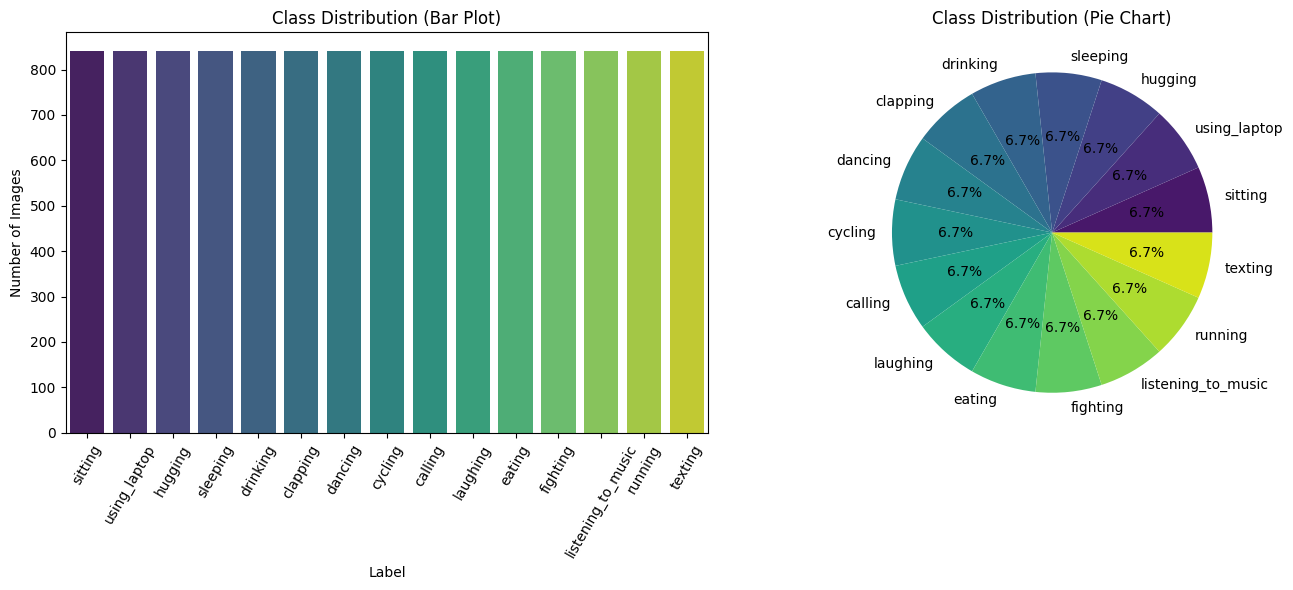

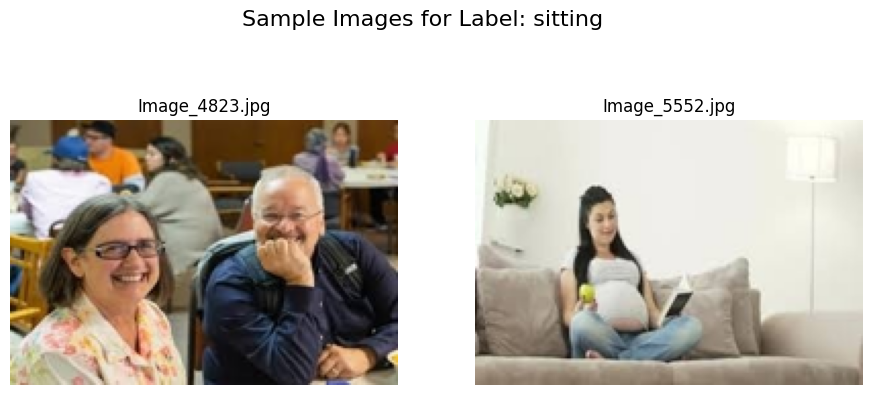

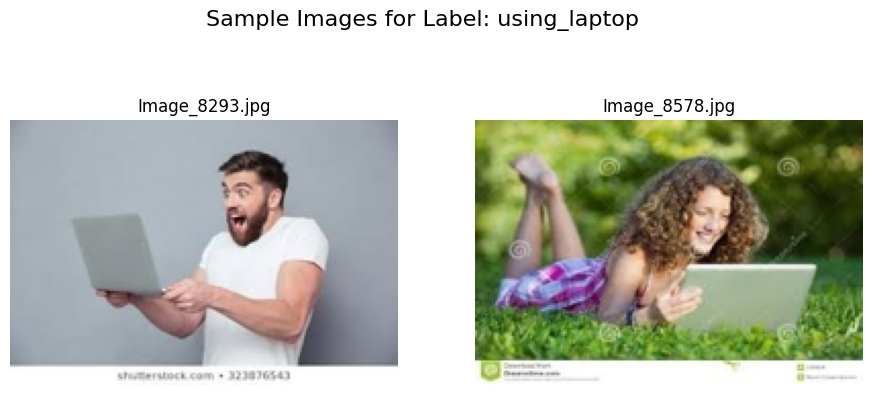

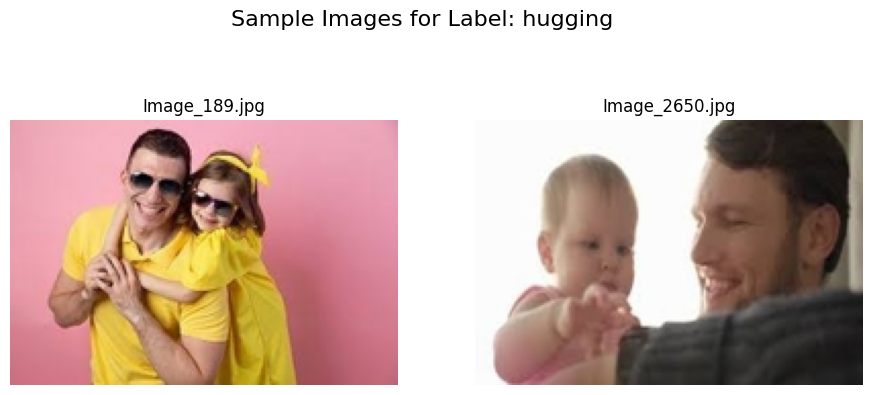

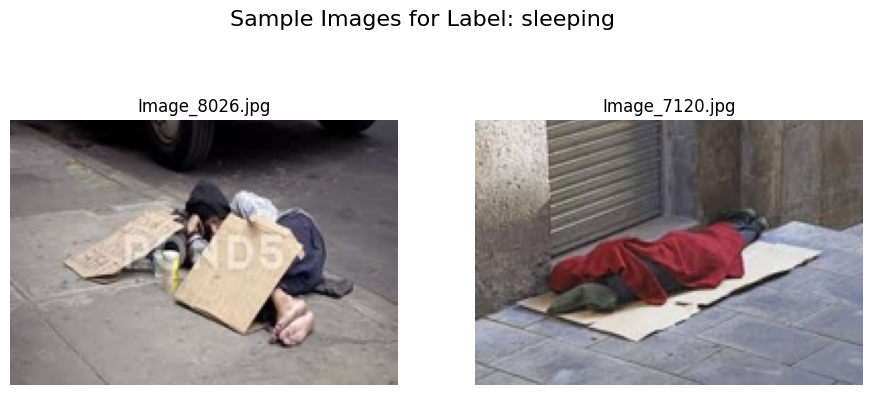

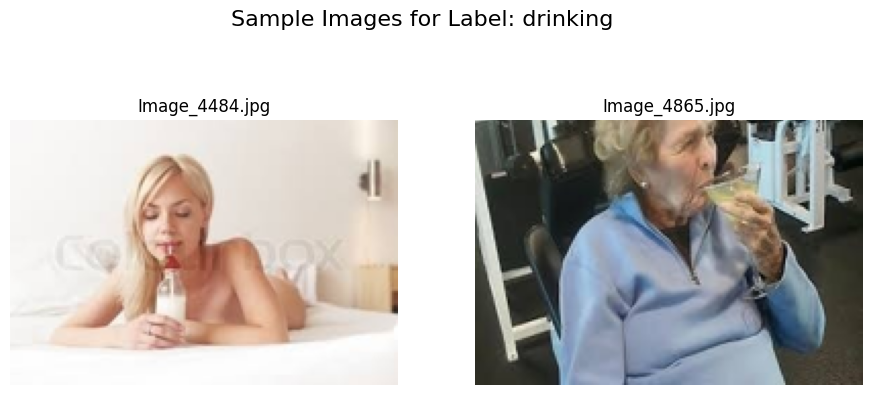

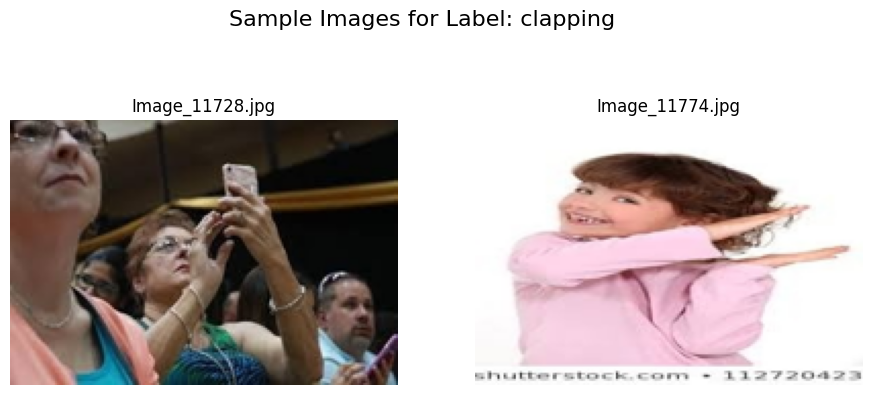

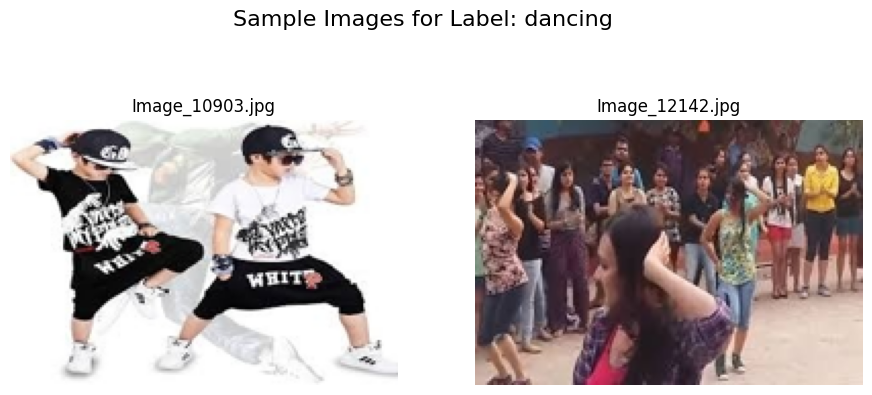

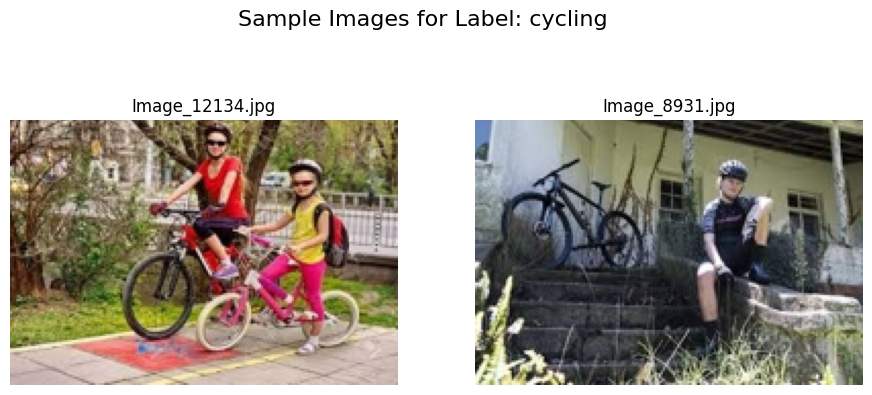

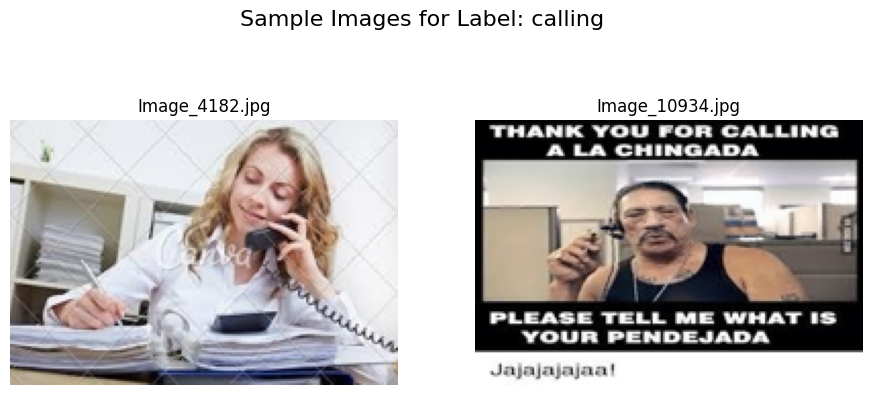

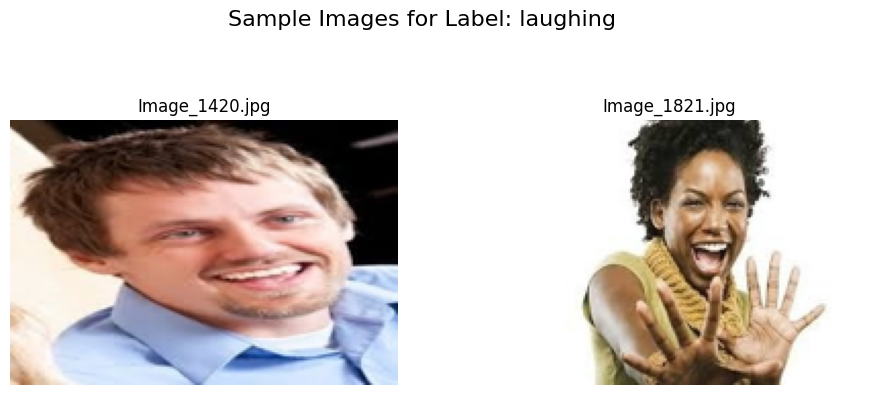

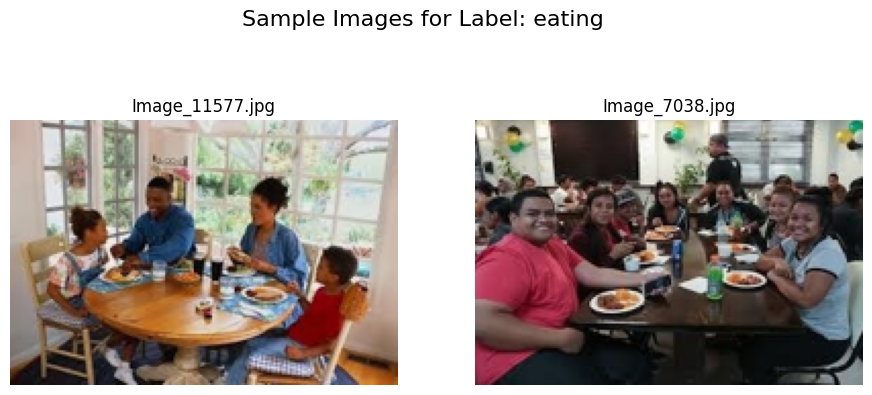

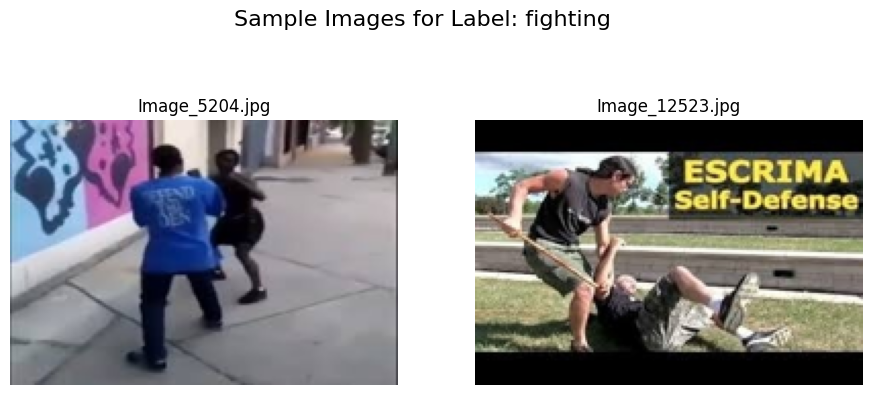

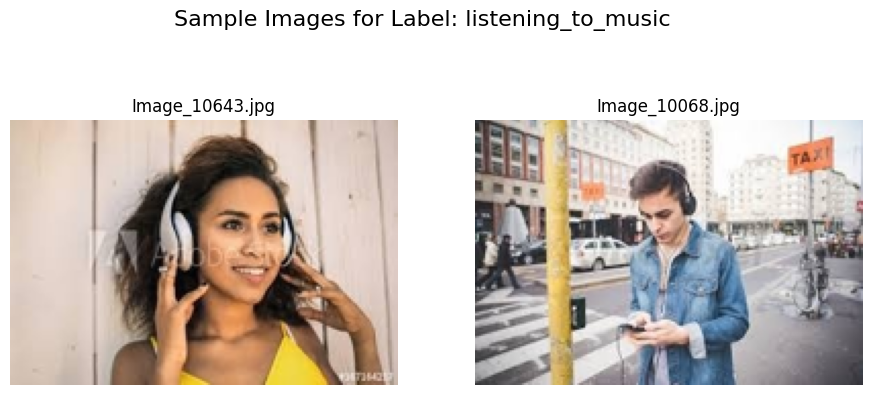

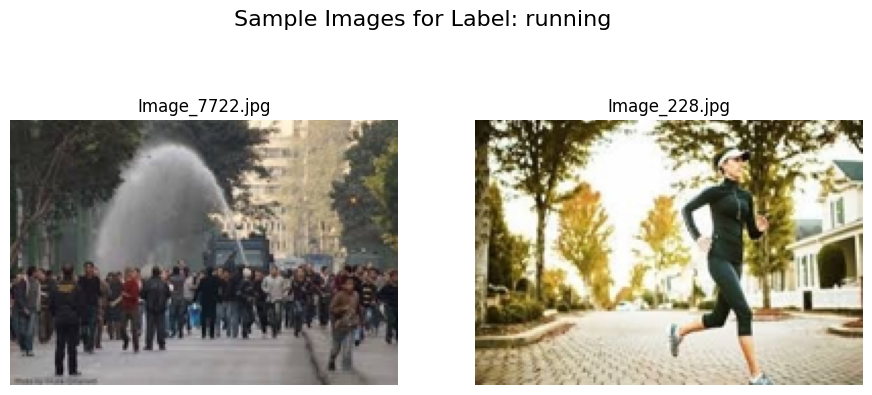

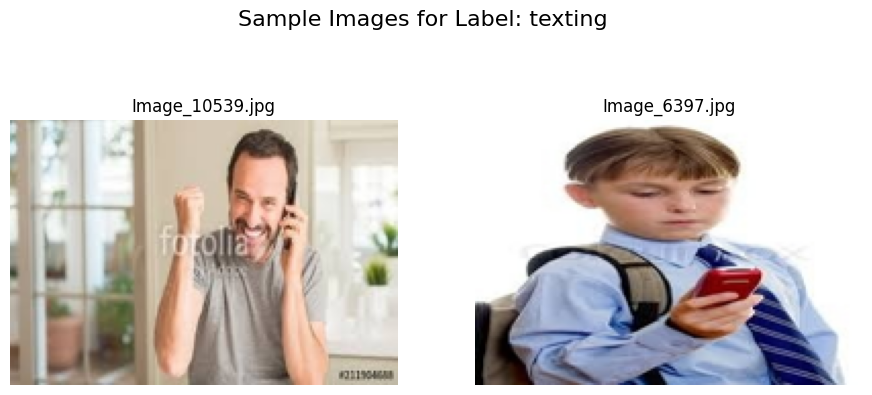

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis', ax=ax[0])
ax[0].set_title('Class Distribution (Bar Plot)')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Number of Images')
ax[0].tick_params(axis='x', rotation=60)

ax[1].pie(class_distribution.values, labels=class_distribution.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(class_distribution)))
ax[1].set_title('Class Distribution (Pie Chart)')

plt.tight_layout()
plt.show()


for label in labels_df['label'].unique():
    label_images = [img_name for img_name, img_data in images.items() if img_data['label'] == label]

    if len(label_images) >= 2:

        fig, axes = plt.subplots(1, 2, figsize=(11, 5))
        fig.suptitle(f"Sample Images for Label: {label}", fontsize=16)

        for i, img_name in enumerate(random.sample(label_images, 2)):
            axes[i].imshow(images[img_name]['image'].resize((190, 130)))
            axes[i].set_title(img_name)
            axes[i].axis('off')

        plt.show()

**Observations**:- The class distribution of images are equal. But by displaying some random images of each class I observed that some images have watermarks and text which might affect the overall accuracy of our model

### **c) Check Class Imbalance**

In [ ]:
def check_class_imbalance(distr):

    table_data = [[label, count, f"{(distr / distr.max())[label]:.2f}"] for label, count in distr.items()]

    print(tabulate.tabulate(table_data, headers=["Class", "Count", "Ratio"], tablefmt="grid"))

In [ ]:
check_class_imbalance(class_distribution)

+--------------------+---------+---------+
| Class              |   Count |   Ratio |
+====================+=========+=========+
| sitting            |     840 |       1 |
+--------------------+---------+---------+
| using_laptop       |     840 |       1 |
+--------------------+---------+---------+
| hugging            |     840 |       1 |
+--------------------+---------+---------+
| sleeping           |     840 |       1 |
+--------------------+---------+---------+
| drinking           |     840 |       1 |
+--------------------+---------+---------+
| clapping           |     840 |       1 |
+--------------------+---------+---------+
| dancing            |     840 |       1 |
+--------------------+---------+---------+
| cycling            |     840 |       1 |
+--------------------+---------+---------+
| calling            |     840 |       1 |
+--------------------+---------+---------+
| laughing           |     840 |       1 |
+--------------------+---------+---------+
| eating   

**Observations**:- Currently there is no class imbalace, but after data filtration there might be chances of class imbalance, so we have to take care of that before feeding data to model.

### Filtering Images

In [ ]:
def filter_images(images, mean_width, std_width, mean_height, std_height):

    return {img_name: data for img_name, data in images.items()
            if  mean_width  - std_width  <= data['size'][0] <= mean_width  + std_width
            and mean_height - std_height <= data['size'][1] <= mean_height + std_height}

In [ ]:
images_std  = pd.DataFrame([img['size'] for img in images.values()], columns=['width', 'height']).std()
images_mean = pd.DataFrame([img['size'] for img in images.values()], columns=['width', 'height']).mean()

filtered_images = filter_images(images, images_mean['width'], images_std['width'], images_mean['height'], images_std['height'])

### Plotting Graph for Comparing Image Sizes Before and After Split

In [ ]:
def compare_dataset_beforeAndAfter_filtering(before_filtering, after_filtering, title):

    widths_after  = [img_data['size'][0] for img_data in after_filtering.values()]
    heights_after = [img_data['size'][1] for img_data in after_filtering.values()]

    widths_before  = [img_data['size'][0] for img_data in before_filtering.values()]
    heights_before = [img_data['size'][1] for img_data in before_filtering.values()]

    fig, ax = plt.subplots(figsize=(10, 7))

    ax.scatter(widths_before, heights_before, c='blue', label='Before Filtering', alpha=0.5)
    ax.scatter(widths_after , heights_after , c='green', label='After Filtering', alpha=0.5)

    ax.set_title(title)
    ax.set_xlabel('Width (pixels)')
    ax.set_ylabel('Height (pixels)')
    ax.legend()

    plt.show()

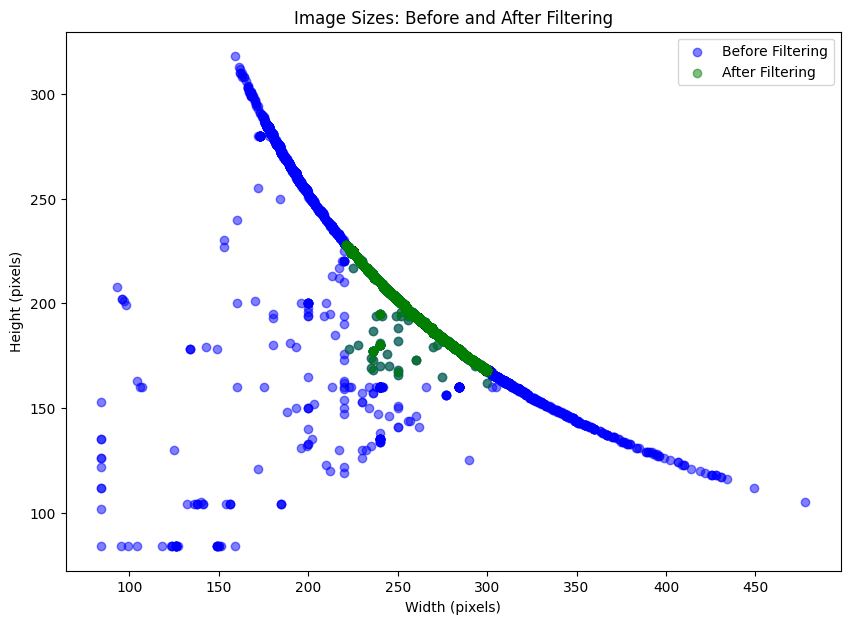

In [ ]:
compare_dataset_beforeAndAfter_filtering(images, filtered_images, title="Image Sizes: Before and After Filtering")

# **Part B: Feature Extraction**

In [ ]:
def resize(image, size=(256, 256)):

    return image.resize(size)

In [ ]:
def extract_HOG(image):

    return hog(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False).flatten()

In [ ]:
def extract_CHIST(image):

    R = cv2.calcHist([np.array(image)], [0], None, [8], [0, 256]).flatten()
    G = cv2.calcHist([np.array(image)], [1], None, [8], [0, 256]).flatten()
    B = cv2.calcHist([np.array(image)], [2], None, [8], [0, 256]).flatten()

    return np.concatenate([R / np.sum(R), G / np.sum(G), B / np.sum(B)])

In [ ]:
def extract_SIFT(image):

    _, des = cv2.SIFT_create().detectAndCompute(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY), None)

    return np.pad(des.flatten()[:500] if des is not None else [], (0, max(0, 500 - (des.size if des is not None else 0))), 'constant')

In [ ]:
def extract_CANNY(image):

    return cv2.Canny(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY), threshold1=100, threshold2=200).flatten()

In [ ]:
def extract_features(image):

    return np.concatenate([extract_HOG(resize(image)), extract_CHIST(resize(image)), extract_SIFT(resize(image)), extract_CANNY(resize(image))])

**Observations**:- I extracted features using four different types of techniques:-

1.   **Histogram of Oriented Gradients (HOG)**:- For extracting texture
     features.
2.   **Color Histograms**:- To distinguish objects in image based on color
     composition.
3.   **Scale Invariant Feature Transform (SIFT)**:- To match objects in images
     with different viewpoints.
4.   **Canny Edge Detection**:- To extract object boundaries.


By the combination of above four techniques I extracted **100656** different features.


### Saving and Loading Features

In [ ]:
def save_features(X, y):

    with open(features_save_path, 'wb') as f:
        pickle.dump((X, y), f)

In [ ]:
def load_features():

    with open(features_save_path, 'rb') as f:
        return pickle.load(f)

### Saving Model

In [ ]:
def save_model(model, X_train, y_train, X_test, y_test):

    with open(best_model_path, 'wb') as f:
        pickle.dump(model, f)

        print(f"\n\nSaved Model to {best_model_path}.\n")

    with open(best_model_training_set_path, 'wb') as f:
        pickle.dump((X_train, y_train), f)

        print(f"\n\nSaved Training Set to {best_model_training_set_path}.\n")


    with open(best_model_testing_set_path, 'wb') as f:
        pickle.dump((X_test, y_test), f)

        print(f"\n\nSaved Testing Set to {best_model_testing_set_path}.\n")

### Extracting features if Previously Extracted features are not available

In [ ]:
X, y = [], []

if os.path.exists(features_save_path):

    print("\nLoading Previously Extracted Features...")
    X, y = load_features()

    print(f"\n\nLoaded {X.shape[0]} feature Vectors with {X.shape[1]} features.\n")

else:

    print("\nExtracting Features...\n")

    for img_name, img_data in tqdm(filtered_images.items(), desc="Extracting Features", colour='green'):
        X.append(extract_features(img_data['image']))
        y.append(img_data['label'])

    X, y = np.array(X), np.array(y)
    print(f"\n\nFeature Extraction Complete. Extracted {X.shape[1]} features from {X.shape[0]} Images.")

    print(f"\n\nSaving Extracted Features to {features_save_path}...\n")
    save_features(X, y)

    print(f"\n\nSaved {X.shape[0]} feature Vectors with {X.shape[1]} features to {features_save_path}.\n")


Loading Previously Extracted Features...


Loaded 9617 feature Vectors with 100656 features.



### Splitting Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Standardizing Training Data

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

### PCA (Dimensionality Reduction) on Training Data

In [ ]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
X_resampled, y_resampled = SMOTE(random_state=42, n_jobs=-1).fit_resample(X_pca, y_train)

In [ ]:
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
def calculate_accuracy(X_test, y_test, title, model = None, save_modell = False):

    if not model and os.path.exists(best_model_path):
        with open(best_model_path, 'rb') as f:
            model = pickle.load(f)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n\n\033[1;34m{title} Test Accuracy: \033[1;92m{accuracy:.4f}\033[0m\n")

    print(f"\nClassification Report for {title}:\n")
    print(classification_report(y_test, y_pred))

    if save_modell: save_model(model, X_resampled, y_resampled, X_test_pca, y_test)

    return accuracy

# **Part C: Model Selection and Evaluation**

In [ ]:
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=2500, random_state=42, n_jobs=-1, oob_score=True, verbose=1),
    'Perceptron': Perceptron(random_state=42, n_jobs=-1)
}

In [ ]:
def evaluate_models(X_train, y_train, X_test, y_test, models):

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)

        results[name] = calculate_accuracy(X_test, y_test, name, model=model, save_modell=False)

    return results

In [ ]:
results = evaluate_models(X_resampled, y_resampled, X_test_pca, y_test, models)



Naive Bayes Test Accuracy: 0.2994


Classification Report for Naive Bayes:

                    precision    recall  f1-score   support

           calling       0.22      0.12      0.15       120
          clapping       0.33      0.22      0.26       136
           cycling       0.48      0.45      0.47       121
           dancing       0.27      0.50      0.35       113
          drinking       0.20      0.10      0.14       124
            eating       0.25      0.63      0.36       131
          fighting       0.32      0.35      0.33       141
           hugging       0.25      0.20      0.22       120
          laughing       0.25      0.38      0.31       117
listening_to_music       0.15      0.05      0.07       132
           running       0.41      0.34      0.37       133
           sitting       0.32      0.16      0.21       128
          sleeping       0.47      0.37      0.41       135
           texting       0.19      0.20      0.20       137
      using_laptop   

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1058 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2258 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    7.3s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done 258 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 608 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 1058 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 1608 tasks      | elapsed:    1.0s
[Parallel(n_jobs=96)]: Done 2258 tasks      | elapsed:    1.3s
[Parallel(n_j



Random Forest Test Accuracy: 0.3404


Classification Report for Random Forest:

                    precision    recall  f1-score   support

           calling       0.26      0.20      0.22       120
          clapping       0.35      0.32      0.33       136
           cycling       0.41      0.62      0.49       121
           dancing       0.41      0.32      0.36       113
          drinking       0.32      0.19      0.24       124
            eating       0.31      0.49      0.38       131
          fighting       0.37      0.40      0.39       141
           hugging       0.35      0.33      0.34       120
          laughing       0.26      0.38      0.31       117
listening_to_music       0.24      0.12      0.16       132
           running       0.45      0.38      0.41       133
           sitting       0.29      0.20      0.23       128
          sleeping       0.42      0.44      0.43       135
           texting       0.25      0.22      0.24       137
      using_lapto

In [ ]:
def display_results(results):

    print(tabulate.tabulate([[model, accuracy] for model, accuracy in results.items()], headers=["Model", "Accuracy"], tablefmt="grid"))

    print(f"\n\n\033[1;34mBest Model: \033[1;92m{max(results, key=results.get)}\033[0m\n\n")

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis', ax=ax)

    ax.set_title('Model Comparison: Accuracy', fontsize=14)
    ax.set_xlabel('Models'  , fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)

    plt.tight_layout()
    plt.show()

+---------------+------------+
| Model         |   Accuracy |
+===============+============+
| Naive Bayes   |   0.299376 |
+---------------+------------+
| Decision Tree |   0.181913 |
+---------------+------------+
| Random Forest |   0.340437 |
+---------------+------------+
| Perceptron    |   0.139813 |
+---------------+------------+


Best Model: Random Forest




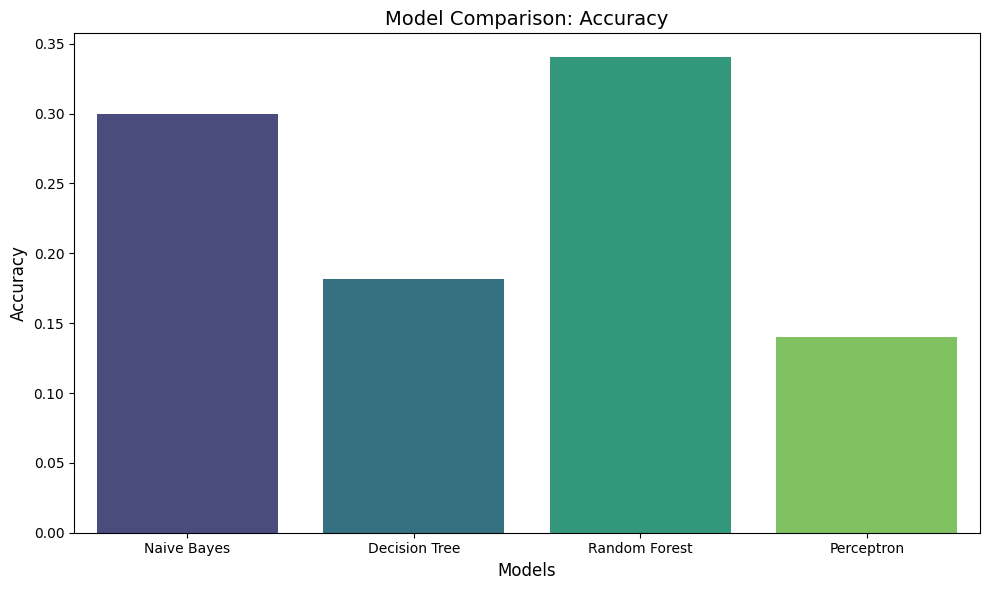

In [ ]:
display_results(results)

**Observations**:- From the Results I observed that Random Forest performed the best among the models, due its ensemble nature. Second is Naive Bayes which might struggles due to high correlated data. Decision Tree and Perceptron model performs very poorly because Decision tree will get overfitted and perceptron model is very simple in nature, so it can't handle the complex image data.

In [ ]:
best_model = models[max(results, key=results.get)]
# save_model(best_model, X_resampled, y_resampled, X_test_pca, y_test)

In [ ]:
with open(best_model_path, 'rb') as f:
    model = pickle.load(f)

with open(best_model_training_set_path, 'rb') as f:
    X_train, y_train = pickle.load(f)

with open(best_model_testing_set_path, 'rb') as f:
    X_test, y_test = pickle.load(f)

calculate_accuracy(X_test, y_test, "Random Forest", model=model, save_modell=False)

[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done 258 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 608 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1058 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1608 tasks      | elapsed:    0.8s




Random Forest Test Accuracy: 0.3519


Classification Report for Random Forest:

                    precision    recall  f1-score   support

           calling       0.23      0.20      0.22       120
          clapping       0.37      0.32      0.34       136
           cycling       0.40      0.62      0.49       121
           dancing       0.42      0.35      0.38       113
          drinking       0.32      0.20      0.25       124
            eating       0.32      0.49      0.39       131
          fighting       0.40      0.46      0.43       141
           hugging       0.38      0.38      0.38       120
          laughing       0.27      0.37      0.31       117
listening_to_music       0.24      0.11      0.15       132
           running       0.46      0.38      0.41       133
           sitting       0.32      0.21      0.25       128
          sleeping       0.46      0.48      0.47       135
           texting       0.24      0.20      0.22       137
      using_lapto

[Parallel(n_jobs=96)]: Done 2258 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 2500 out of 2500 | elapsed:    1.2s finished


0.3518711018711019

**Observations**:- Loading and Testing the best Model.